## SIM Training by Stein's Method

In [21]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SimRegressor
clf = SimRegressor(method="first_order", spline="a_spline", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="a_spline"

        "p_spline": p-spline (from pygam package)
    
        "p_spline_mono": p-spline with monotonic constraint (from pygam package)
    
        "a_spline": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [22]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [24]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=10, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   15.4s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   19.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   20.1s finished


CPU times: user 2.59 s, sys: 8.22 s, total: 10.8 s
Wall time: 20.6 s


In [25]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 1.0, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [26]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_num=10, method='first_order', random_state=0,
             reg_gamma=1.0, reg_lambda=0.05, spline='a_spline')

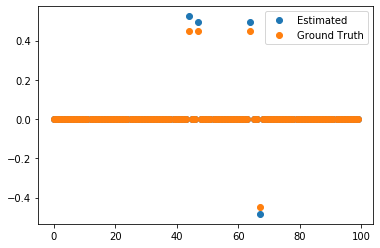

In [27]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

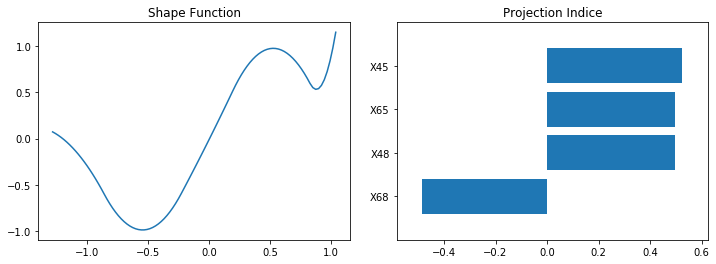

In [28]:
clf.visualize()
plt.show()

In [44]:
import scipy
import numpy as np
import pandas as pd 
from scipy.linalg import cholesky
from patsy import dmatrix, build_design_matrices

clf = grid.best_estimator_.shape_fit_
sample_weight = np.ones(n_samples)
x, y = clf._validate_input(x, y)

knots = list(np.linspace(clf.xmin, clf.xmax, clf.knot_num + 2, dtype=np.float32)[1:-1])
xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
           {"x": [clf.xmin, clf.xmax], "knots": knots, "degree": clf.degree})
init_basis = np.asarray(build_design_matrices([xphi.design_info],
           {"x": x, "knots": knots, "degree": clf.degree})[0])

best_loss = np.inf
D = clf.diff_matrix(clf.degree, clf.knot_num)
update_w = np.ones([clf.knot_num, 1], dtype=np.float32) 
BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), y, axes=([0], [0]))
for i in range(clf.maxiter):
    DwD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
    U = cholesky(BWB + clf.reg_gamma * DwD)
    M = scipy.linalg.lapack.clapack.dtrtri(U)[0]
    update_a_temp = np.dot(np.dot(M, M.T.conj()), BWY)
    new_loss = clf._get_loss(y, np.dot(init_basis, update_a_temp))
    if new_loss - best_loss >= 0:
        break
    best_loss = new_loss
    update_a = update_a_temp
    update_w = 1 / (np.dot(D, update_a) ** 2 + clf.epsilon ** 2)

clf.selected_knots_ = list(np.array(knots)[np.reshape(update_w * np.dot(D, update_a) ** 2 > clf.threshold, [-1])])
clf.selected_xphi_ = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
       {"x": [clf.xmin, clf.xmax], "knots": clf.selected_knots_, "degree": clf.degree})
selected_basis = np.asarray(build_design_matrices([clf.selected_xphi_.design_info],
                  {"x": x, "knots": clf.selected_knots_, "degree": clf.degree})[0])
seBWB = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), selected_basis, axes=([0], [0]))
seBWY = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), y, axes=([0], [0]))
np.dot(np.linalg.pinv(seBWB), seBWY)


array([ 0.07242118, -0.07658835, -1.38046409, -0.06986769,  1.39358701,
        0.33142755,  1.14994609])

In [46]:
from sklearn.utils import check_array, check_X_y, column_or_1d
y = column_or_1d(y, warn=False)
y

array([ 1.45574254,  1.77070435,  0.74211315, ..., -0.93986408,
        0.2745256 , -1.14202375])

In [33]:
grid.best_estimator_.shape_fit_.decision_function(np.dot(x, grid.best_estimator_.beta_))

array([-0.08617568,  0.24996863,  0.08711032, ...,  0.55759211,
        0.54408326, -0.61703453])

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [8]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + np.random.randn(n_samples)

In [9]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.02, 0.04, 0.08, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=50, spline="a_spline", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 174 out of 200 | elapsed:   42.6s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


CPU times: user 3.72 s, sys: 10.7 s, total: 14.5 s
Wall time: 1min 37s


In [10]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 10.0, 'reg_lambda': 0.02}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [11]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_num=50, method='second_order', random_state=0,
             reg_gamma=10.0, reg_lambda=0.02, spline='a_spline')

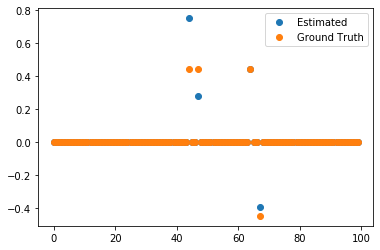

In [12]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

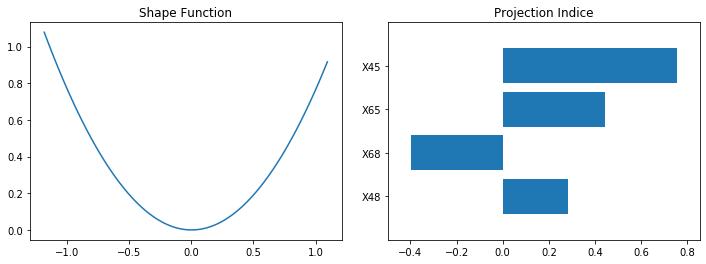

In [13]:
clf.visualize()

## Case 3: Monotonic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = e^{-u} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [14]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.exp(- np.dot(x, beta)) + np.random.randn(n_samples)

- monotonic p-spline

In [15]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=50, spline="a_spline", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed:    9.8s remaining:   30.9s
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:   16.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished


CPU times: user 4.29 s, sys: 9.88 s, total: 14.2 s
Wall time: 19 s


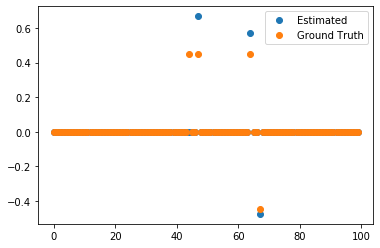

In [16]:
plt.plot(grid.best_estimator_.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

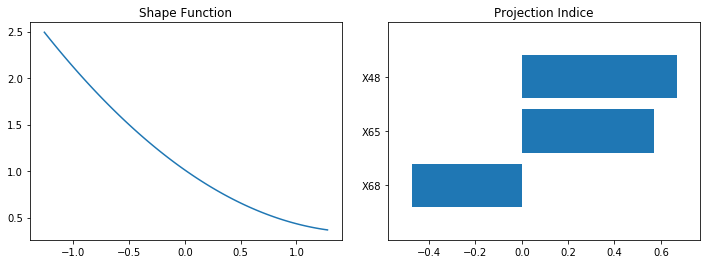

In [17]:
grid.best_estimator_.visualize()
plt.show()